In [1]:
import importlib.util
if importlib.util.find_spec('empylib') is None:
    !pip install git+https://github.com/PanxoPanza/empylib.git

# Teoria del color

## Introducción

Para nuestros ojos, una fuente de luz tiene coloración blanca cuando la intensidad de cada frecuencia del espectro visible es, aproximadamente, constante.

El mejor ejemplo es el sol.
<img src="./images/solar_spectrum.jpg" width="500px" align= center>

## Espacio de colores CIE RGB

Los colores aparecen cuando el espectro de la fuente no está ditribuido de forma uniforme. Nuestros ojos, encargados de intrepretar este espectro como color, poseen *células fotoreceptoras o conos celulares* sensibles a los colores: <font color='red'>rojo (R)</font>, <font color='green'>verde (G)</font> y <font color='blue'>azul (B)</font>

Matemáticamente, existen diversas formas de transformar un espectro, $I_\mathrm{spec}(\lambda)$, a **código de colores RGB**. En este curso, usamos el módulo `ref_spectra.color_system` de la librería `empylib`, el cual está basado en [Comisión internacional de la iluminación (CIE)](https://es.wikipedia.org/wiki/Espacio_de_color_CIE_1931)

En términos simples, el procedimiento consiste en determinar los **valores triestímulo $X$, $Y$ y $Z$** a partir de las **funciones de combinación de colores $\bar{x}(\lambda)$, $\bar{y}(\lambda)$ y $\bar{z}(\lambda)$,** que representan la precepción visual humana de forma numérica:

\begin{equation*}
X = \int_{0}^\infty I_\mathrm{spec}(\lambda)\bar{x}(\lambda) d\lambda,\quad\quad
Y = \int_{0}^\infty I_\mathrm{spec}(\lambda)\bar{y}(\lambda) d\lambda,\quad\quad
Z = \int_{0}^\infty I_\mathrm{spec}(\lambda)\bar{z}(\lambda) d\lambda,
\end{equation*}

Analicemos el comportamiento de las funciones de combinación de colores.

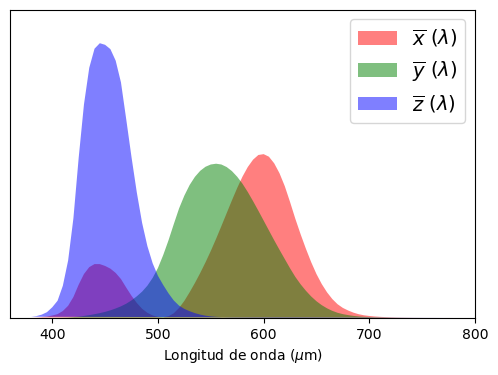

In [2]:
import matplotlib.pyplot as plt

# librería para transformación de espectro a código RGB
from empylib.ref_spectra import color_system as cs
cs = cs.srgb

# formateamos el lienzo de la figura
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
plt.rcParams['font.size'] = '14'

# Graficamos cada curva del estandar CIE XYZ
plt.fill(cs.lam_cmf,cs.cmf[:,0],color='red'  ,alpha=0.5,edgecolor=None,label='$\overline{x}~(\lambda)$')
plt.fill(cs.lam_cmf,cs.cmf[:,1],color='green',alpha=0.5,edgecolor=None,label='$\overline{y}~(\lambda)$')
plt.fill(cs.lam_cmf,cs.cmf[:,2],color='blue' ,alpha=0.5,edgecolor=None,label='$\overline{z}~(\lambda)$')

# Ajustamos formato de ejes
plt.ylim(0,2)
plt.tick_params(left = False,labelleft = False)
plt.xlabel('Longitud de onda ($\mu$m)')
plt.legend();

Posterior a esto, el código de colores $\mathrm{RGB}$ se determina a partir del sistema:

\begin{equation*}
\begin{bmatrix}
0.187 & 0.063 & 0.064 \\
0.092 & 0.212 & 0.025 \\
0     & 0.024 & 0.334 \\
\end{bmatrix}\left[\begin{array}{c} \mathrm{R} \\\mathrm{G} \\\mathrm{B} \end{array}\right] =
\left[\begin{array}{c} x \\y \\z\end{array}\right]
\end{equation*}

donde $xyz$ están dados por:

\begin{equation*}
x = \frac{X}{X+Y+Z},\quad\quad\quad y = \frac{Y}{X+Y+Z},\quad\quad\quad z = \frac{Z}{X+Y+Z},
\end{equation*}

## Modelos de colores


### Coloración aditiva
Es un modelo que explica la obtención de un color a partir de la suma de los componentes primarios, comúnmente, rojo, verde y azul. La coloración aditiva es el método utilizado en monitores electrónicos, como LCD, LED, oLED, etc.

<img src="./images/additive_colors.jpg" width="700px" align= center>

Analicemos el siguiente modelo de colores aditivos.

In [3]:
# importamos librerías necesarias
import empylib as em
import empylib.nklib as nk
import empylib.ref_spectra as rf
import empylib.waveoptics as wv
import matplotlib.pyplot as plt
import numpy as np

def plot_additive_color(R,G,B):
    # lienzo para la figura
    fig, ax = plt.subplots()          
    fig.set_size_inches(6, 4)         # Tamaño del gráfico
    plt.rcParams['font.size'] = '14'  # tamaño de  fuente

    # Espectro de longitudes de onda entre 300 y 800 nm
    lam = np.linspace(0.3,0.8,500)

    # Generamos un material con emisividad en rojo, verde y azul
    wn = em.convert_units(np.array([450, 520, 630]),'nm','eV')
    wp = [B*0.02,G*0.02,R*0.02]  # Frecuencia wp (eV)
    T  = 0.05    # Taza de decaimiento (eV)

    eps_mat = complex(1,0)
    for i in range(len(wn)):
        # constante dieléctrica según modelo de Lorentz
        eps_mat = eps_mat + (nk.lorentz(0,wp[i],wn[i],T,lam))**2

    N_mat = np.sqrt(eps_mat)

    Rw, Tw = wv.incoh_multilayer(lam,0, (1.0,N_mat,1.0), 200)
    Ew = 1 - Rw - Tw;

    # Graficamos el espectro de emisión
    ax.plot(lam*1E3,Ew*100)
    ax.set_ylabel('Emisividad (%)')
    ax.set_xlabel('Longitud de onda ($\mu$m)')
    ax.set_ylim(0,100)

    # interpretacion de colores
    Dcircle = 0.30
    ax2 = fig.add_axes([0.63,0.55, Dcircle, Dcircle])
    html_rgb = cs.spec_to_rgb(Ew*rf.AM15(lam),lam, out_fmt='html')
    Circle = plt.Circle((0, 0), Dcircle, color=html_rgb)
    ax2.add_patch(Circle)
    ax2.set_aspect('equal')
    ax2.set_xlim(-Dcircle*1.2,Dcircle*1.2)
    ax2.set_ylim(-Dcircle*1.2,Dcircle*1.2)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_facecolor('k');

In [4]:
from ipywidgets import interact

@interact(R=(0,1,0.1), G=(0,1,0.1), B=(0,1,0.1))
def g(R = 1, G = 1, B = 1):
    return plot_additive_color(R,G,B)

interactive(children=(FloatSlider(value=1.0, description='R', max=1.0), FloatSlider(value=1.0, description='G'…

### Coloración sustractiva
Se basa en la formación de colores a partir de la sustracción de colores primarios. Comúnmente, se utilizan los colores amarillo, cian y magenta.

El modelo, explica la coloración de muchas frutas, verduras y plantas. Además, es la técnica utilizada en impresión a color, fotografía y cinematografía.

<img src="./images/substractive_colors.png" width="700px" align= center>

El siguiente modelo explica el concepto de coloración sustractiva

In [5]:
# importamos librerías necesarias
import empylib as em
import empylib.nklib as nk
import empylib.ref_spectra as rf
import empylib.waveoptics as wv
import matplotlib.pyplot as plt
import numpy as np

def plot_substractive_color(R,G,B):
    # lienzo para la figura
    fig, ax = plt.subplots()          
    fig.set_size_inches(6, 4)         # Tamaño del gráfico
    plt.rcParams['font.size'] = '14'  # tamaño de  fuente

    # Espectro de longitudes de onda entre 300 y 800 nm
    lam = np.linspace(0.3,0.8,100)

    # Generamos un material con emisividad en rojo, verde y azul
    wn = em.convert_units(np.array([450, 520, 630]),'nm','eV')
    wp = [B*0.02,G*0.02,R*0.02]  # Frecuencia wp (eV)
    T  = 0.05                    # Tasa de decaimiento (eV)
    
    eps_mat = complex(1,0)
    for i in range(len(wn)):
        # constante dieléctrica según modelo de Lorentz
        eps_mat = eps_mat + (nk.lorentz(0,wp[i],wn[i],T,lam))**2

    N_mat = np.sqrt(eps_mat)

    Rw, Tw = wv.incoh_multilayer(lam,0, (1.0,N_mat,1.0), 200)
    Ew = 1 - Rw - Tw
    Rw = (1 - Ew)

    # Graficamos el espectro de emisión
    ax.plot(lam*1E3,(1 - Ew)*100)
    ax.set_ylabel('Reflectancia (%)')
    ax.set_xlabel('Longitud de onda ($\mu$m)')
    ax.set_ylim(0,100)

    # interpretacion de colores
    Dcircle = 0.30
    ax2 = fig.add_axes([0.63,0.55, Dcircle, Dcircle])
    html_rgb = cs.spec_to_rgb(Rw*rf.AM15(lam),lam, out_fmt='html')
    Circle = plt.Circle((0, 0), Dcircle, color=html_rgb)
    ax2.add_patch(Circle)
    ax2.set_aspect('equal')
    ax2.set_xlim(-Dcircle*1.2,Dcircle*1.2)
    ax2.set_ylim(-Dcircle*1.2,Dcircle*1.2)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_facecolor('k');
    
    plt.show()

In [6]:
from ipywidgets import interact

@interact(R=(0,1,0.1), G=(0,1,0.1), B=(0,1,0.1))
def g(R = 1, G = 0, B = 0):
    return plot_substractive_color(R,G,B)

interactive(children=(FloatSlider(value=1.0, description='R', max=1.0), FloatSlider(value=0.0, description='G'…

## Referencias
**Hetch E., *Óptica*, 5ta Ed, Pearson, 2017**
- Capítulo 4.9: Aspectos conocidos de la interacción de la luz y la materia